In [19]:
# ----------------------------------------------------------------------------
# Read data from Spark Thrift Server
# ----------------------------------------------------------------------------

import pandas as pd
from pyhive import hive

# Connect to Spark Thrift Server
host = "spark-thrift"
port = 10000
username = "spark"
database = "default"
table = "dbt_gold_eta_features"

conn = hive.Connection(
    host=host,
    port=port,
    username=username,
    database=database
)

query = f"SELECT * FROM {table}"
df = pd.read_sql(query, conn)
conn.close()

print("===== RAW DATA SAMPLE =====")
display(df.head())

/tmp/ipykernel_16/1540159689.py:23: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


===== RAW DATA SAMPLE =====


start_date   trip_id  current_stop_sequence        arrival_time  \
0   20250220  101561H0                      7 2025-02-20 08:21:32   
1   20250220  101561H0                      8 2025-02-20 08:22:29   
2   20250220  101561H0                      9 2025-02-20 08:24:31   
3   20250220  101561H0                     10 2025-02-20 08:26:32   
4   20250220  101561H0                     11 2025-02-20 08:28:30   

       departure_time   next_arrival_time  travel_time_second  \
0 2025-02-20 08:21:32 2025-02-20 08:22:29                57.0   
1 2025-02-20 08:23:30 2025-02-20 08:24:31               122.0   
2 2025-02-20 08:25:32 2025-02-20 08:26:32               121.0   
3 2025-02-20 08:27:29 2025-02-20 08:28:30               118.0   
4 2025-02-20 08:28:30 2025-02-20 08:29:31                61.0   

  scheduled_arrival_time scheduled_departure_time next_scheduled_arrival_time  \
0    2025-02-20 08:20:00      2025-02-20 08:21:00         2025-02-20 08:22:00   
1    2025-02-20 08:22:00      2025-02-20 08:23:00         2025-02-20 08:24:00   
2    2025-02-20 08:24:00      2025-02-20 08:25:00         2025-02-20 08:26:00   
3    2025-02-20 08:26:00      2025-02-20 08:26:00         2025-02-20 08:27:00   
4    2025-02-20 08:27:00      2025-02-20 08:28:00         2025-02-20 08:29:00   

   scheduled_travel_time_second  departure_delay_time_second  \
0                         120.0                        -32.0   
1                         120.0                        -30.0   
2                         120.0                        -32.0   
3                          60.0                        -89.0   
4                         120.0                        -30.0   

   producer_timestamp  
0 2025-02-20 08:22:16  
1 2025-02-20 08:24:16  
2 2025-02-20 08:26:16  
3 2025-02-20 08:28:16  
4 2025-02-20 08:29:16

In [20]:
# ----------------------------------------------------------------------------
# Data Cleaning
# ----------------------------------------------------------------------------

import pandas as pd

# 1) Calculate the maximum `current_stop_sequence` for each `start_date` and `trip_id`
max_seq = (
    df.groupby(["start_date", "trip_id"])["current_stop_sequence"]
    .max()
    .reset_index(name="max_seq")
)

# 2) Merge the `max_seq` DataFrame with the original df
df_merged = df.merge(max_seq, on=["start_date", "trip_id"], how="left")

# 3) Conditions to remove:
#    (a) `current_stop_sequence` = max_seq AND `next_arrival_time` is null
#    (b) `travel_time_second` < 0
cond_end_null = (
    (df_merged["current_stop_sequence"] == df_merged["max_seq"]) &
    df_merged["next_arrival_time"].isnull()
)
cond_negative = (df_merged["travel_time_second"] < 0)
cond_remove = cond_end_null | cond_negative

print("Rows to remove:", df_merged[cond_remove].shape[0])

# 4) Exclude those rows and drop `max_seq`
df_filtered = df_merged[~cond_remove].copy()
df_filtered.drop(columns=["max_seq"], inplace=True)
print("After cleaning, df_filtered shape:", df_filtered.shape)

# Overwrite original df with cleaned version
df = df_filtered

display(df.head())

Rows to remove: 5538
After cleaning, df_filtered shape: (94092, 13)


start_date   trip_id  current_stop_sequence        arrival_time  \
0   20250220  101561H0                      7 2025-02-20 08:21:32   
1   20250220  101561H0                      8 2025-02-20 08:22:29   
2   20250220  101561H0                      9 2025-02-20 08:24:31   
3   20250220  101561H0                     10 2025-02-20 08:26:32   
4   20250220  101561H0                     11 2025-02-20 08:28:30   

       departure_time   next_arrival_time  travel_time_second  \
0 2025-02-20 08:21:32 2025-02-20 08:22:29                57.0   
1 2025-02-20 08:23:30 2025-02-20 08:24:31               122.0   
2 2025-02-20 08:25:32 2025-02-20 08:26:32               121.0   
3 2025-02-20 08:27:29 2025-02-20 08:28:30               118.0   
4 2025-02-20 08:28:30 2025-02-20 08:29:31                61.0   

  scheduled_arrival_time scheduled_departure_time next_scheduled_arrival_time  \
0    2025-02-20 08:20:00      2025-02-20 08:21:00         2025-02-20 08:22:00   
1    2025-02-20 08:22:00      2025-02-20 08:23:00         2025-02-20 08:24:00   
2    2025-02-20 08:24:00      2025-02-20 08:25:00         2025-02-20 08:26:00   
3    2025-02-20 08:26:00      2025-02-20 08:26:00         2025-02-20 08:27:00   
4    2025-02-20 08:27:00      2025-02-20 08:28:00         2025-02-20 08:29:00   

   scheduled_travel_time_second  departure_delay_time_second  \
0                         120.0                        -32.0   
1                         120.0                        -30.0   
2                         120.0                        -32.0   
3                          60.0                        -89.0   
4                         120.0                        -30.0   

   producer_timestamp  
0 2025-02-20 08:22:16  
1 2025-02-20 08:24:16  
2 2025-02-20 08:26:16  
3 2025-02-20 08:28:16  
4 2025-02-20 08:29:16

In [33]:
# ----------------------------------------------------------------------------
# Data Profiling
# ----------------------------------------------------------------------------

print("===== df.info() =====")
df.info()

print("\n===== df.describe() =====")
display(df.describe(include='all', datetime_is_numeric=True))

# Advanced data exploration with ydata_profiling
from ydata_profiling import ProfileReport
profile = ProfileReport(df, title="ETA Dataset Profiling")
profile.to_notebook_iframe()


===== df.info() =====
<class 'pandas.core.frame.DataFrame'>
Int64Index: 75130 entries, 1 to 99628
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   start_date                    75130 non-null  object        
 1   trip_id                       75130 non-null  object        
 2   current_stop_sequence         75130 non-null  int64         
 3   arrival_time                  75130 non-null  datetime64[ns]
 4   departure_time                75130 non-null  datetime64[ns]
 5   next_arrival_time             75130 non-null  datetime64[ns]
 6   travel_time_second            75130 non-null  float64       
 7   scheduled_arrival_time        75034 non-null  datetime64[ns]
 8   scheduled_departure_time      75034 non-null  datetime64[ns]
 9   next_scheduled_arrival_time   74792 non-null  datetime64[ns]
 10  scheduled_travel_time_second  74726 non-null  float64       
 11  depart

start_date   trip_id  current_stop_sequence  \
count       75130     75130           75130.000000   
unique          7      3368                    NaN   
top      20250221  411411A0                    NaN   
freq        25774        93                    NaN   
mean          NaN       NaN              14.165673   
min           NaN       NaN               1.000000   
25%           NaN       NaN               6.000000   
50%           NaN       NaN              13.000000   
75%           NaN       NaN              20.000000   
max           NaN       NaN              38.000000   
std           NaN       NaN               9.299444   

                         arrival_time                 departure_time  \
count                           75130                          75130   
unique                            NaN                            NaN   
top                               NaN                            NaN   
freq                              NaN                            NaN   
mean    2025-02-23 03:43:55.047331328  2025-02-23 03:45:04.644882176   
min               2025-02-20 08:21:04            2025-02-20 08:21:04   
25%               2025-02-21 06:39:02            2025-02-21 06:40:34   
50%               2025-02-23 10:29:01            2025-02-23 10:30:31   
75%               2025-02-24 08:13:31            2025-02-24 08:14:32   
max               2025-02-26 06:58:33            2025-02-26 06:59:34   
std                               NaN                            NaN   

                    next_arrival_time  travel_time_second  \
count                           75130        75130.000000   
unique                            NaN                 NaN   
top                               NaN                 NaN   
freq                              NaN                 NaN   
mean    2025-02-23 03:46:06.236150784          131.188819   
min               2025-02-20 08:23:05           85.000000   
25%               2025-02-21 06:41:35          118.000000   
50%               2025-02-23 10:31:29          122.000000   
75%               2025-02-24 08:15:34          150.000000   
max               2025-02-26 07:00:32          183.000000   
std                               NaN           26.648638   

               scheduled_arrival_time       scheduled_departure_time  \
count                           75034                          75034   
unique                            NaN                            NaN   
top                               NaN                            NaN   
freq                              NaN                            NaN   
mean    2025-02-23 03:42:29.399472384  2025-02-23 03:43:03.635152384   
min               2025-02-20 08:17:00            2025-02-20 08:18:00   
25%               2025-02-21 06:38:00            2025-02-21 06:39:00   
50%               2025-02-23 10:28:00            2025-02-23 10:29:00   
75%               2025-02-24 08:13:00            2025-02-24 08:13:00   
max               2025-02-26 06:58:00            2025-02-26 06:59:00   
std                               NaN                            NaN   

          next_scheduled_arrival_time  scheduled_travel_time_second  \
count                           74792                  74726.000000   
unique                            NaN                           NaN   
top                               NaN                           NaN   
freq                              NaN                           NaN   
mean    2025-02-23 03:43:53.694913792                    126.948987   
min               2025-02-20 08:20:00                     30.000000   
25%               2025-02-21 06:41:00                    120.000000   
50%               2025-02-23 10:30:00                    120.000000   
75%               2025-02-24 08:15:00                    120.000000   
max               2025-02-26 07:01:00                    720.000000   
std                               NaN                     40.492469   

        departure_delay_time_second       

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
# ----------------------------------------------------------------------------
# Remove Outliers
# ----------------------------------------------------------------------------

'''
import numpy as np
import pandas as pd

# 1) calculate the IQR (Interquartile Range)
Q1 = df["travel_time_second"].quantile(0.25)
Q3 = df["travel_time_second"].quantile(0.75)
IQR = Q3 - Q1

# 2) see records outside the IQR range (outliers)
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# 3) Remove outliers
df_no_outlier = df[
    (df["travel_time_second"] >= lower_bound) & 
    (df["travel_time_second"] <= upper_bound)
].copy()

print("Before outlier removal:", len(df))
print("After outlier removal:", len(df_no_outlier))

# 4) use df_no_outlier for further analysis 
df = df_no_outlier
'''

Before outlier removal: 94092
After outlier removal: 75130


In [40]:
# ----------------------------------------------------------------------------
# Feature Engineering
# ----------------------------------------------------------------------------

import pandas as pd

# Convert columns to proper dtypes if needed

df["travel_time_second"] = df["travel_time_second"].astype(float)
df["departure_delay_time_second"] = df["departure_delay_time_second"].astype(float)
df["scheduled_travel_time_second"] = df["scheduled_travel_time_second"].astype(float)
df["current_stop_sequence"] = df["current_stop_sequence"].astype(int)

# Create day_of_week, hour_of_day
df["day_of_week"] = df["arrival_time"].dt.weekday  # 0=Monday,6=Sunday
df["hour_of_day"] = df["arrival_time"].dt.hour

print("===== After Feature Engineering =====")
display(df.head())


===== After Feature Engineering =====


start_date   trip_id  current_stop_sequence        arrival_time  \
1   20250220  101561H0                      8 2025-02-20 08:22:29   
2   20250220  101561H0                      9 2025-02-20 08:24:31   
3   20250220  101561H0                     10 2025-02-20 08:26:32   
5   20250220  101561H0                     12 2025-02-20 08:29:31   
8   20250220  101577H0                      1 2025-02-20 08:21:32   

       departure_time   next_arrival_time  travel_time_second  \
1 2025-02-20 08:23:30 2025-02-20 08:24:31               122.0   
2 2025-02-20 08:25:32 2025-02-20 08:26:32               121.0   
3 2025-02-20 08:27:29 2025-02-20 08:28:30               118.0   
5 2025-02-20 08:30:32 2025-02-20 08:31:32               121.0   
8 2025-02-20 08:22:29 2025-02-20 08:23:30               118.0   

  scheduled_arrival_time scheduled_departure_time next_scheduled_arrival_time  \
1    2025-02-20 08:22:00      2025-02-20 08:23:00         2025-02-20 08:24:00   
2    2025-02-20 08:24:00      2025-02-20 08:25:00         2025-02-20 08:26:00   
3    2025-02-20 08:26:00      2025-02-20 08:26:00         2025-02-20 08:27:00   
5    2025-02-20 08:29:00      2025-02-20 08:30:00         2025-02-20 08:31:00   
8    2025-02-20 08:22:00      2025-02-20 08:22:00         2025-02-20 08:23:00   

   scheduled_travel_time_second  departure_delay_time_second  \
1                         120.0                        -30.0   
2                         120.0                        -32.0   
3                          60.0                        -89.0   
5                         120.0                        -32.0   
8                          60.0                        -29.0   

   producer_timestamp  depature_delay_time_second  day_of_week  hour_of_day  \
1 2025-02-20 08:24:16                       -30.0            3            8   
2 2025-02-20 08:26:16                       -32.0            3            8   
3 2025-02-20 08:28:16                       -89.0            3            8   
5 2025-02-20 08:31:16                       -32.0            3            8   
8 2025-02-20 08:23:16                       -29.0            3            8   

   trip_id_encoded  
1              150  
2              150  
3              150  
5              150  
8              156

In [41]:
# ----------------------------------------------------------------------------
# Split train/test data
# ----------------------------------------------------------------------------

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

le = LabelEncoder()
df["trip_id_encoded"] = le.fit_transform(df["trip_id"])

feature_cols = ["trip_id_encoded", "current_stop_sequence", "day_of_week", "hour_of_day",
                "scheduled_travel_time_second", "departure_delay_time_second"]

# sort by timestamp ascending
df_sorted = df.sort_values("producer_timestamp")

# split test for the most recent 20% data and train for the rest
cutoff = int(len(df_sorted) * 0.8)
df_train = df_sorted.iloc[:cutoff].copy()
df_test  = df_sorted.iloc[cutoff:].copy()

# split features and target
X_train = df_train[feature_cols]
y_train = df_train["travel_time_second"]
X_test  = df_test[feature_cols]
y_test  = df_test["travel_time_second"]


In [42]:
# ----------------------------------------------------------------------------
# Build Baseline Model
# ----------------------------------------------------------------------------

# consolidate the train data
train_data = X_train.copy()
train_data["travel_time_second"] = y_train

# group by (trip_id, current_stop_sequence, day_of_week, hour_of_day)
group_cols = ["trip_id_encoded", "current_stop_sequence", "day_of_week", "hour_of_day"]

# calculate the mean travel time for each group (trip_id, current_stop_sequence, day_of_week, hour_of_day)
baseline_means = train_data.groupby(group_cols)["travel_time_second"].mean()

# overall mean travel time for fallback
global_mean = train_data["travel_time_second"].mean()

print("Number of baseline groups:", len(baseline_means))
print("Global mean (fallback):", global_mean)

Number of baseline groups: 60104
Global mean (fallback): 130.9096233195794


In [43]:
# ----------------------------------------------------------------------------
# Predict and Evaluate with Baseline Model
# ----------------------------------------------------------------------------

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# there are (trip_id, current_stop_sequence, day_of_week, hour_of_day) in test data
test_data = X_test.copy()

def baseline_predict(row):
    key = (
        row["trip_id_encoded"],
        row["current_stop_sequence"],
        row["day_of_week"],
        row["hour_of_day"]
    )
    if key in baseline_means:
        return baseline_means[key]
    else:
        # fallback to global mean
        return global_mean

# create a new column "baseline_pred" in test_data
test_data["baseline_pred"] = test_data.apply(baseline_predict, axis=1)

# compare with actual travel time
mae_base = mean_absolute_error(y_test, test_data["baseline_pred"])
rmse_base = mean_squared_error(y_test, test_data["baseline_pred"], squared=False)
r2_base = r2_score(y_test, test_data["baseline_pred"])

print("===== Baseline Model (Train→Test) =====")
print(f"MAE : {mae_base:.2f}")
print(f"RMSE: {rmse_base:.2f}")
print(f"R^2 : {r2_base:.2f}")


===== Baseline Model (Train→Test) =====
MAE : 21.29
RMSE: 26.44
R^2 : -0.00


In [44]:
# ----------------------------------------------------------------------------
# Build Regression Model
# ----------------------------------------------------------------------------

from xgboost import XGBRegressor

model = XGBRegressor(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mae_xgb = mean_absolute_error(y_test, y_pred)
rmse_xgb = mean_squared_error(y_test, y_pred, squared=False)

mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print("===== Regression Model Results =====")
print(f"MAE : {mae:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"R^2 : {r2:.3f}")


===== Regression Model Results =====
MAE : 15.122
RMSE: 20.782
R^2 : 0.380


In [39]:
# ----------------------------------------------------------------------------
# Validate Predictions
# ----------------------------------------------------------------------------

print("=== Compare Baseline vs Regression ===")
print(f"Baseline  - MAE={mae_base:.2f}, RMSE={rmse_base:.2f}, R^2={r2_base:.2f}")
print(f"XGBoost   - MAE={mae:.2f},  RMSE={rmse:.2f}, R^2={r2:.2f}")

=== Compare Baseline vs Regression ===
Baseline  - MAE=21.29, RMSE=26.44, R^2=-0.00
XGBoost   - MAE=15.12,  RMSE=20.78, R^2=0.38


In [74]:
print("len(X_test)=", len(X_test))
print("len(errors)=", len(errors))
print(errors.head(10))

len(X_test)= 10976
len(errors)= 13600
52008    12.505875
31767   -29.947876
38641    48.330917
13430    25.490265
5913     55.608505
59260    -9.741463
43277     8.981392
57745    29.009338
23782   -57.089447
57306   -69.514374
Name: travel_time_second, dtype: float64


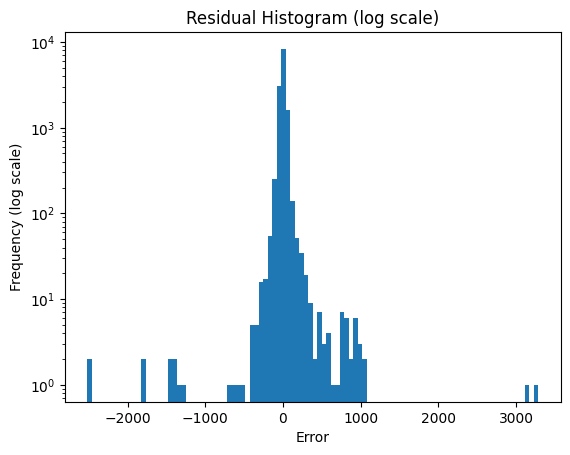

In [64]:
errors = y_test - y_pred   # residuals
abs_errors = abs(errors)   # absolute residuals

%matplotlib inline
import matplotlib.pyplot as plt

plt.hist(errors, bins=100, log=True)
plt.title("Residual Histogram (log scale)")
plt.xlabel("Error")
plt.ylabel("Frequency (log scale)")
plt.show()

plt.show()